In [1]:
import numpy as np
import torch
from matplotlib import pyplot as plt

/Users/ktamogashev/miniforge/envs/sb/lib/python3.11/site-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3638.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


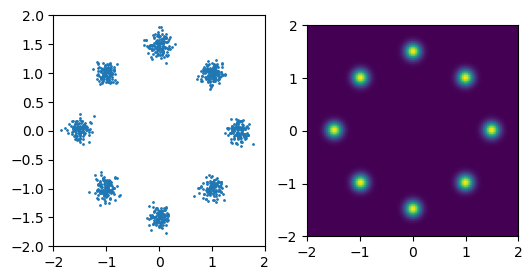

In [2]:
modes = torch.tensor([[0, -1], [1, 1], [-1, 1]], dtype=torch.float32)
var=0.2**2

modes = torch.tensor([[-2, 2], [2, 2],
                       [-3, 0], [3, 0],
                       [0, -3], [0, 3],
                       [-2, -2], [2, -2]]
                       ).float() * 1.0
modes /= 2
var /= 4


def sample(n):
    return torch.randn(n, 2)*np.sqrt(var) + modes[torch.randint(0, len(modes), (n,))]

def logdensity(x):
    distances = x[...,None] - modes.T
    return (-distances**2/(2*var) - 0.5*np.log(2*np.pi*var)).sum(1).logsumexp(-1) - np.log(len(modes))

plt.figure(figsize=(6,3))

plt.subplot(121)
plt.xlim(-2,2);plt.ylim(-2,2)
dataset = sample(1000)
plt.scatter(dataset[:, 0], dataset[:, 1], s=1)

plt.subplot(122)
X = torch.meshgrid(torch.linspace(-2, 2, 100), torch.linspace(-2, 2, 100))
X = torch.stack(X, -1).view(-1, 2)
plt.imshow(logdensity(X).exp().view(100, 100).numpy().T[::-1], extent=(-2, 2, -2, 2))

plt.show()

In [3]:
nn = torch.nn.Sequential(torch.nn.Linear(3, 256), torch.nn.ELU(), torch.nn.Linear(256, 256), torch.nn.ELU(), torch.nn.Linear(256, 2))
opt = torch.optim.Adam(nn.parameters(), lr=1e-3)

0 [ 141.45068359 -141.45068359   -1.06286526]


/var/folders/cx/2l1rdkkx5vg9h87plft2cx2w0000gn/T/ipykernel_59124/642036860.py:25: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  x_next = x + drift*dt + torch.randn_like(x)*np.sqrt(dt) * max(1, 2 - it / 1000)


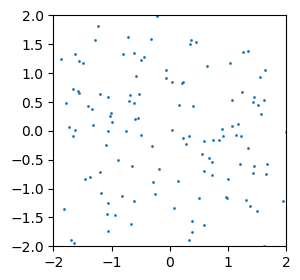

100 [ 29.61726866 -29.61726866   1.26129487]


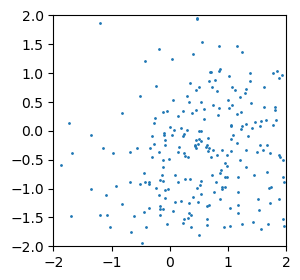

200 [ 24.8034717  -24.8034717    1.93616214]


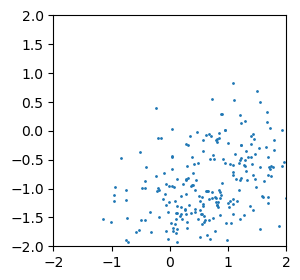

300 [ 21.55078341 -21.55078341   0.59392097]


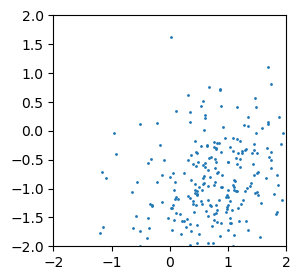

400 [ 18.51977639 -18.51977639  -0.56183307]


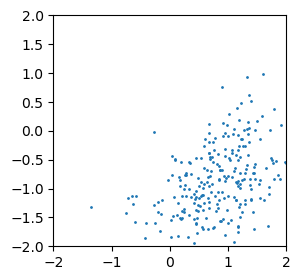

500 [ 16.0011954  -16.0011954   -0.48314991]


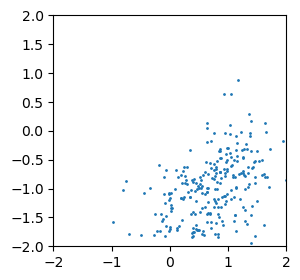

600 [ 14.00167573 -14.00167573  -0.78020466]


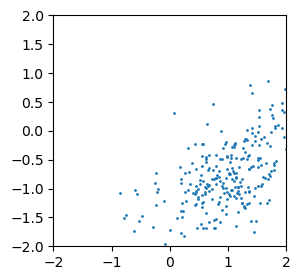

700 [ 12.08126855 -12.08126855  -0.69823157]


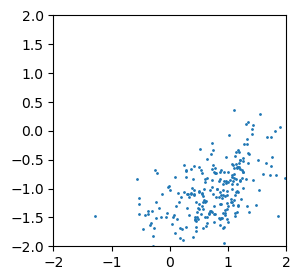

KeyboardInterrupt: 

In [4]:
# PIS / TB

loss_type = 'pis'

bs = 256
N = 20
Tmax = 1
dt = torch.tensor(Tmax/N)
losses = []

def lognormal(x, mean, var): return -0.5 * ((x - mean)**2 / var + var.log() + np.log(2*np.pi)).sum(-1)

for it in range(10000):
    opt.zero_grad()

    x = torch.zeros((bs, 2))
    t = torch.zeros((bs, 1))

    logpf = torch.zeros((bs,))
    logpb = torch.zeros((bs,))
    logr = torch.zeros((bs,))

    for i in range(N):
        drift = nn(torch.cat([x, t], -1))
        x_next = x + drift*dt + torch.randn_like(x)*np.sqrt(dt) * max(1, 2 - it / 1000)
        if loss_type != 'pis': x_next = x_next.detach()
        logpf += lognormal(x_next, x + drift*dt, dt)
        if i > 0: logpb += lognormal(x, x_next * t / (t+dt), dt * t / (t+dt))

        x = x_next
        t = t + dt

    logr = logdensity(x)

    logz = (logr + logpb - logpf).mean()
    logz_iw = (logr + logpb - logpf).logsumexp(-1) - np.log(bs)

    if loss_type == 'pis':
        loss = -(logr + logpb - logpf).mean()
    elif loss_type == 'vargrad':
        loss = ((logr + logpb - logpf) - logz.detach()).pow(2).mean()

    loss.backward()
    opt.step()

    losses.append((loss.item(), logz.item(), logz_iw.item()))

    if it % 100 == 0:
        print(it, np.array(losses)[-100:].mean(0))
    if it % 100 == 0:
        plt.figure(figsize=(3,3))
        plt.scatter(x[:, 0].detach().numpy(), x[:, 1].detach().numpy(), s=1)
        plt.xlim(-2,2);plt.ylim(-2,2)
        plt.show()


In [ ]:
np.log(2/3)

-0.40546510810816444

In [ ]:
nn = torch.nn.Sequential(torch.nn.Linear(3, 256), torch.nn.ELU(), torch.nn.Linear(256, 256), torch.nn.ELU(), torch.nn.Linear(256, 2))
opt = torch.optim.Adam(nn.parameters(), lr=1e-3)
energy = torch.nn.Sequential(torch.nn.Linear(2, 64), torch.nn.ELU(), torch.nn.Linear(64, 64), torch.nn.ELU(), torch.nn.Linear(64, 1))
opt_energy = torch.optim.Adam(energy.parameters(), lr=1e-4)

0 [0.86378801 2.94960189 3.54918671 0.0079313 ]


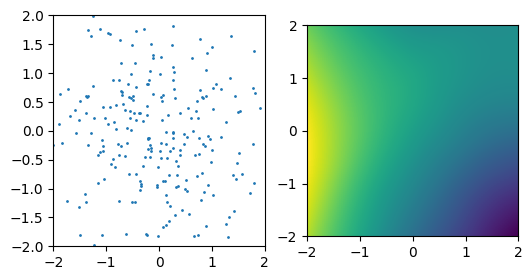

100 [ 0.98266876  4.21905454  5.10560594 -0.20567133]
200 [ 0.41437819  4.12838996  4.45315318 -0.68077759]
300 [ 0.14079929  3.93857237  4.0216844  -0.84217889]
400 [ 0.05847166  3.90285632  3.93419888 -0.67880192]
500 [ 0.02730503  3.96056272  3.97470022 -0.48137312]
600 [ 0.01369494  4.03940976  4.04688465 -0.35004193]
700 [ 0.00809433  4.11063507  4.11477216 -0.2536191 ]
800 [ 0.00598067  4.15968385  4.16273679 -0.19753074]
900 [ 0.00605289  4.18274062  4.18577242 -0.15700988]
1000 [ 0.00661639  4.1718543   4.17514458 -0.13317277]


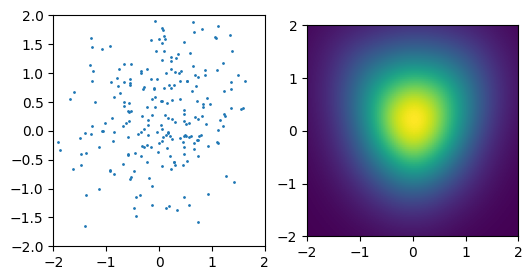

1100 [ 0.0074242   4.13983004  4.14350149 -0.12684454]
1200 [ 0.00930644  4.07868949  4.08329851 -0.11917406]
1300 [ 0.01063841  4.00721066  4.0124554  -0.12507994]
1400 [ 0.0121816   3.91259408  3.91857968 -0.10758466]
1500 [ 0.01384225  3.79413496  3.80093476 -0.11806081]
1600 [ 0.01728931  3.63887678  3.64734086 -0.1434201 ]
1700 [ 0.01992547  3.46789309  3.47764164 -0.16492721]
1800 [ 0.02337906  3.26371007  3.27510206 -0.19044802]
1900 [ 0.0277562   3.04649387  3.06002253 -0.21721905]
2000 [ 0.03341204  2.78913839  2.80528286 -0.26506814]


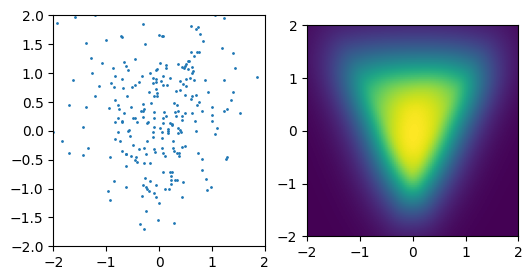

2100 [ 0.03869752  2.53263483  2.55138684 -0.30859892]
2200 [ 0.04735897  2.25404269  2.27696497 -0.35051406]
2300 [ 0.06328035  1.9698129   2.00078666 -0.41407122]
2400 [ 0.07400219  1.67240679  1.70823659 -0.4727995 ]
2500 [ 0.08755859  1.36326133  1.40538369 -0.54810276]
2600 [ 0.11200746  1.05967009  1.11344783 -0.61488454]
2700 [ 0.14017604  0.74137695  0.80824563 -0.68831905]
2800 [ 0.16852971  0.44174924  0.52184713 -0.75020156]
2900 [ 0.21470955  0.12554556  0.22750216 -0.82219743]
3000 [ 0.24809863 -0.16071807 -0.04337525 -0.87671254]


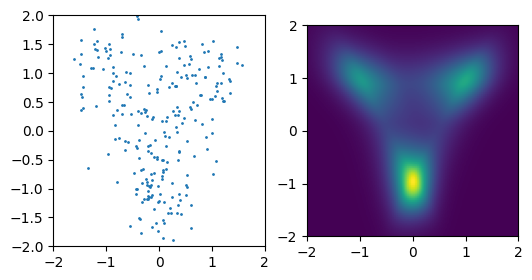

3100 [ 0.29367338 -0.4405587  -0.30318753 -0.93891547]
3200 [ 0.34856242 -0.72755258 -0.56452738 -0.98821355]
3300 [ 0.4086449  -0.98381214 -0.79569563 -1.0367539 ]
3400 [ 0.48299512 -1.24291993 -1.02468993 -1.07827242]
3500 [ 0.54796656 -1.47811652 -1.23165464 -1.1182506 ]
3600 [ 0.63896649 -1.69866742 -1.41447555 -1.14255287]
3700 [ 0.69735721 -1.8741195  -1.56641816 -1.14419386]


KeyboardInterrupt: 

In [ ]:
# PIS with energy

bs = 256
N = 20
Tmax = 1
dt = torch.tensor(Tmax/N)
loss_type = 'vargrad'
losses = []

def lognormal(x, mean, var): return -0.5 * ((x - mean)**2 / var + var.log() + np.log(2*np.pi)).sum(-1)

for it in range(10000):
    opt.zero_grad()

    x = torch.zeros((bs, 2))
    t = torch.zeros((bs, 1))

    logpf = torch.zeros((bs,))
    logpb = torch.zeros((bs,))
    logr = torch.zeros((bs,))

    for i in range(N):
        drift = nn(torch.cat([x, t], -1))
        x_next = x + drift*dt + torch.randn_like(x)*np.sqrt(dt)# * max(1, 2 - it / 1000)
        if loss_type != 'pis': x_next = x_next.detach()
        logpf += lognormal(x_next, x + drift*dt, dt)
        if i > 0: logpb += lognormal(x, x_next * t / (t+dt), dt * t / (t+dt))

        x = x_next
        t = t + dt

    logr = -energy(x)[...,0]

    logz = (logr + logpb - logpf).mean()
    logz_iw = (logr + logpb - logpf).logsumexp(-1) - np.log(bs)

    if loss_type == 'pis':
        loss = -(logr + logpb - logpf).mean()
    elif loss_type == 'vargrad':
        loss = ((logr + logpb - logpf) - logz.detach()).pow(2).mean()

    loss.backward()
    opt.step()

    

    opt_energy.zero_grad()
    neg = energy(x.detach()).mean()
    pos = energy(dataset).mean()
    loss_energy = pos - neg
    loss_energy.backward()
    opt_energy.step()

    losses.append((loss.item(), logz.item(), logz_iw.item(), loss_energy.item()))

    if it % 100 == 0:
        print(it, np.array(losses)[-100:].mean(0))
    if it % 1000 == 0:
        plt.figure(figsize=(6,3))
        plt.subplot(121)
        plt.scatter(x[:, 0].detach().numpy(), x[:, 1].detach().numpy(), s=1)
        plt.xlim(-2,2);plt.ylim(-2,2)

        plt.subplot(122)
        X = torch.meshgrid(torch.linspace(-2, 2, 100), torch.linspace(-2, 2, 100))
        X = torch.stack(X, -1).view(-1, 2)
        with torch.no_grad():
            plt.imshow((-energy(X)).exp().view(100, 100).numpy().T[::-1], extent=(-2, 2, -2, 2))
        plt.show()


In [39]:

# class GMM(torch.nn.Module):
#     def __init__(self, K):
#         super().__init__()
#         self.means = torch.nn.Parameter(torch.randn(K, 2).requires_grad_())
#         self.vars = torch.nn.Parameter(torch.zeros(K, 2).requires_grad_())
#         self.weights = torch.nn.Parameter(torch.zeros(K,).requires_grad_())
#     def forward(self, x):
#         x = x[:, None, :]
#         means = self.means[None, :, :].tanh() * 2
#         vars = self.vars[None, :, :].exp()
#         weights = self.weights[None, :].log_softmax(-1)
#         return -(-0.5 * ((x - means)**2 / vars + vars.log() + np.log(2*np.pi)).sum(-1) + weights).logsumexp(-1)

# energy = GMM(8)

nn = torch.nn.Sequential(torch.nn.Linear(3, 256), torch.nn.ELU(), torch.nn.Linear(256, 256), torch.nn.ELU(), torch.nn.Linear(256, 4))
nn_back = torch.nn.Sequential(torch.nn.Linear(3, 256), torch.nn.ELU(), torch.nn.Linear(256, 256), torch.nn.ELU(), torch.nn.Linear(256, 4))
opt = torch.optim.Adam([ {'params': nn.parameters(), 'lr':1e-3}, {'params': nn_back.parameters(), 'lr':1e-4}])
energy = torch.nn.Sequential(torch.nn.Linear(2, 256), torch.nn.ELU(), torch.nn.Linear(256, 256), torch.nn.ELU(), torch.nn.Linear(256, 1))

opt_energy = torch.optim.Adam(energy.parameters(), lr=1e-4)

0 [  0.15090489 -54.96544647  -0.3990221 ]


/var/folders/cx/2l1rdkkx5vg9h87plft2cx2w0000gn/T/ipykernel_59124/2281956509.py:30: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  x_next = x + drift*dt + torch.randn_like(x)*np.sqrt(dt)*(var.sqrt())# + (0 if it%2==0 else 0.25))


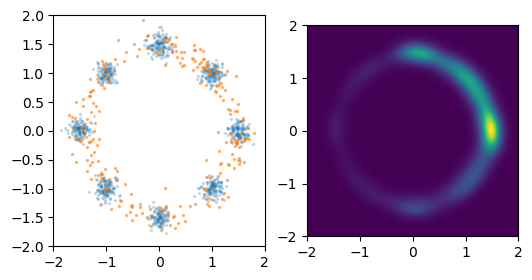

100 [  0.11986816 -55.99428127  -0.43839034]
200 [  0.1084338  -56.34700054  -0.44853162]
300 [  0.10251191 -57.55329689  -0.43546478]
400 [  0.09954536 -57.09313179  -0.43796164]
500 [  0.11060964 -57.47517765  -0.4369846 ]
600 [  0.09501701 -57.24432671  -0.41825436]
700 [  0.0963954  -59.36550522  -0.39293124]
800 [  0.11325169 -59.23835236  -0.42195756]
900 [  0.09394539 -58.70976784  -0.41499589]
1000 [  0.09235384 -59.33600338  -0.41191406]


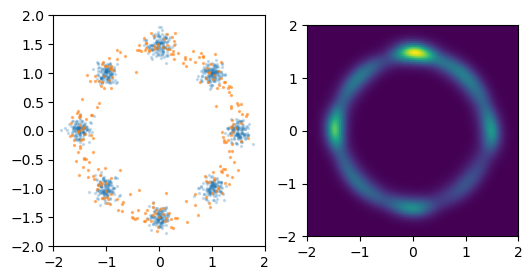

1100 [  0.10615718 -59.73520966  -0.40733717]
1200 [  0.10152558 -59.41877274  -0.4349487 ]
1300 [  0.09426556 -60.23264973  -0.41488987]
1400 [  0.10272285 -59.45190434  -0.41069421]
1500 [  0.10122239 -59.62239475  -0.42659205]
1600 [  0.09931331 -60.02077644  -0.42195073]
1700 [  0.08752257 -61.28107376  -0.39683162]
1800 [  0.09924543 -60.49614307  -0.43009067]
1900 [  0.08826709 -61.84955708  -0.39262347]
2000 [  0.09070584 -60.60576061  -0.4261766 ]


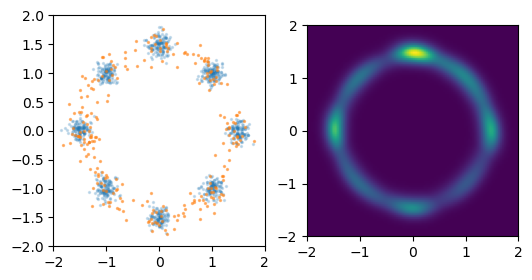

2100 [  0.10381059 -62.03650661  -0.39444373]
2200 [  0.10101824 -61.3191      -0.43616818]
2300 [  0.094487   -63.2492244   -0.39259698]
2400 [  0.09473593 -62.36254333  -0.42927848]
2500 [  0.09378709 -62.49959957  -0.41790489]
2600 [  0.09777171 -61.99488819  -0.41016883]
2700 [  0.09128856 -62.63346081  -0.41471699]
2800 [  0.09931904 -61.91615959  -0.42569704]
2900 [  0.09071411 -62.41688335  -0.41360049]
3000 [  0.09413262 -61.74721519  -0.42393466]


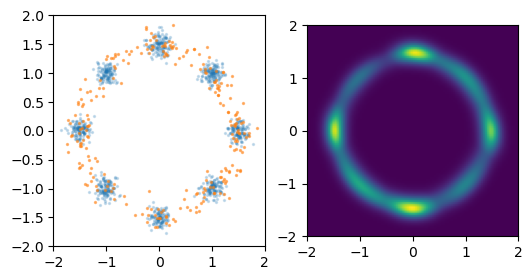

3100 [  0.09937873 -61.92629372  -0.41701854]
3200 [  0.09798592 -61.95771553  -0.42131186]
3300 [  0.09637922 -62.83821434  -0.39992826]
3400 [  0.09069114 -62.50648437  -0.41811045]
3500 [  0.09346505 -61.6210981   -0.43130714]
3600 [  0.09991974 -62.56933681  -0.3961354 ]
3700 [  0.08413925 -63.37067146  -0.40416526]
3800 [  0.08754911 -64.23681526  -0.39095519]
3900 [  0.09252293 -62.69550961  -0.43222894]
4000 [  0.10897839 -62.49088421  -0.42007318]


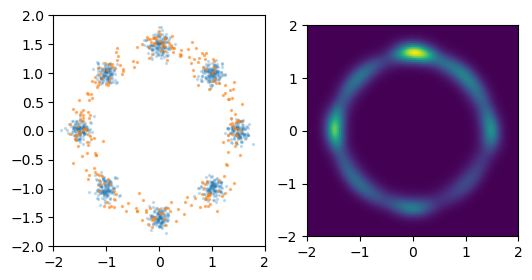

4100 [  0.09908632 -63.36322701  -0.3947737 ]
4200 [  0.10000059 -63.70829884  -0.38690992]
4300 [  0.09520958 -64.11318787  -0.40255635]
4400 [  0.08711715 -65.91243439  -0.37652205]
4500 [  0.09015316 -65.13618484  -0.40182168]
4600 [  0.09297428 -64.70982269  -0.40424006]
4700 [  0.10421035 -64.06167671  -0.42218407]
4800 [  0.09634411 -65.42465904  -0.38881347]
4900 [  0.09853954 -64.84874973  -0.41069711]
5000 [  0.11320256 -64.41093365  -0.41907297]


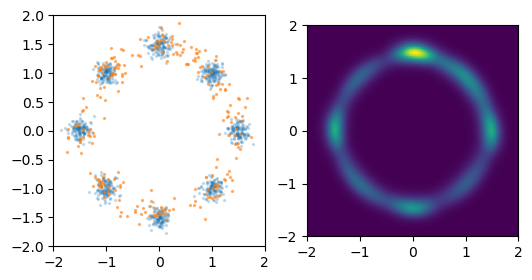

5100 [  0.10773905 -63.55890312  -0.42116274]
5200 [  0.09481267 -64.88172455  -0.37384251]
5300 [  0.10271522 -65.04778324  -0.40501483]
5400 [  0.10152156 -64.6510054   -0.39635697]
5500 [  0.10092029 -64.65982548  -0.39624589]
5600 [  0.09124831 -66.19378235  -0.38143826]
5700 [  0.10180134 -65.39661858  -0.41487599]
5800 [  0.09718868 -65.07119347  -0.40051387]
5900 [  0.10551238 -65.40759457  -0.39505535]
6000 [  0.09547019 -65.84033821  -0.40586805]


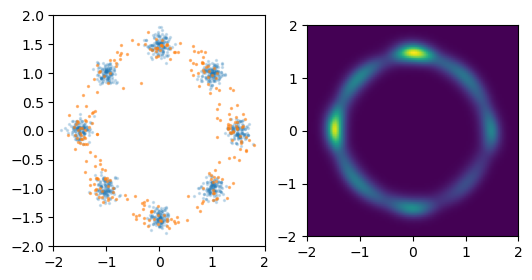

6100 [  0.10149213 -65.51396866  -0.41173125]
6200 [  0.09524145 -65.87712231  -0.39077824]
6300 [  0.10150083 -65.4779068   -0.39787764]
6400 [  0.09307878 -66.67038635  -0.39282564]
6500 [  0.09903326 -68.1748835   -0.36560969]
6600 [  0.10469359 -66.57115631  -0.40838526]
6700 [  0.10094972 -66.67068169  -0.41494448]
6800 [  0.09707115 -66.8747406   -0.40811432]
6900 [  0.08967322 -68.57730423  -0.38547494]
7000 [  0.08573133 -68.95072418  -0.38551491]


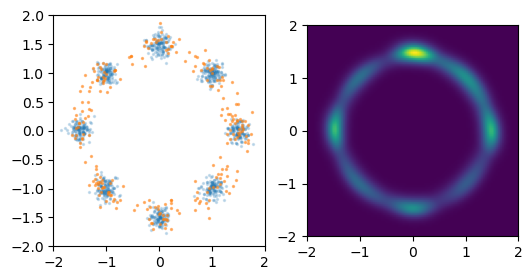

7100 [  0.09453182 -68.72105667  -0.38586226]
7200 [  0.09680411 -67.73629341  -0.41254951]
7300 [  0.10254564 -68.13226097  -0.4177966 ]
7400 [  0.09453954 -67.74457359  -0.41030014]
7500 [  0.09480111 -68.39546555  -0.39358923]
7600 [  0.08368949 -69.31283142  -0.38544614]
7700 [  0.08986288 -68.71414001  -0.39955811]
7800 [  0.09572281 -69.81300293  -0.38427978]
7900 [  0.09700999 -69.2606176   -0.39896896]
8000 [  0.10189717 -68.69306068  -0.40767561]


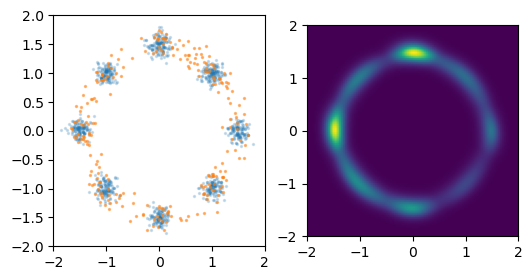

8100 [  0.08960556 -69.33699776  -0.38764441]
8200 [  0.09222259 -69.68464035  -0.37428791]
8300 [  0.10390677 -70.34413994  -0.39556755]
8400 [  0.09858587 -70.44534203  -0.39236343]
8500 [  0.10221369 -71.26180489  -0.37853816]
8600 [  0.09761849 -70.55335716  -0.3987966 ]
8700 [  0.10126117 -69.39884438  -0.40688337]
8800 [  0.09181834 -70.28264015  -0.37586888]
8900 [  0.09909479 -69.95638046  -0.39583748]
9000 [  0.09724154 -70.09718201  -0.39319054]


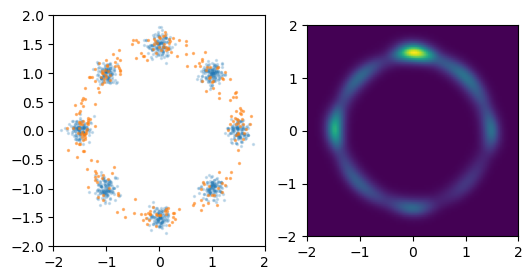

9100 [  0.10366955 -71.24763557  -0.37976397]
9200 [  0.10246636 -71.4792675   -0.39454741]
9300 [  0.0972612  -73.09059402  -0.35511082]
9400 [  0.1017288  -71.98800903  -0.40084724]
9500 [  0.10184435 -69.71101662  -0.41368152]
9600 [  0.09841034 -71.45700386  -0.37730214]
9700 [  0.09824971 -71.84728905  -0.37490184]
9800 [  0.09533728 -72.40576523  -0.38073796]
9900 [  0.09911197 -72.52294525  -0.38847367]
10000 [  0.10556167 -71.43255692  -0.40410342]


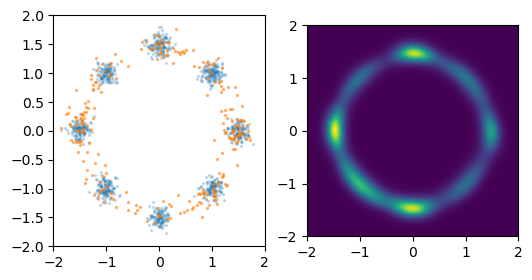

10100 [  0.10030928 -71.34394295  -0.39516359]
10200 [  0.09569102 -72.12192863  -0.37298868]
10300 [  0.09115679 -72.26551231  -0.37968246]
10400 [  0.08797896 -73.02408257  -0.37282285]
10500 [  0.09830128 -72.67432831  -0.38173179]
10600 [  0.09608642 -72.93342819  -0.3746087 ]
10700 [  0.10391202 -72.57081055  -0.38756256]
10800 [  0.09606566 -72.88464714  -0.37600368]
10900 [  0.09294855 -72.41405945  -0.39923228]
11000 [  0.10186331 -71.3358326   -0.40322404]


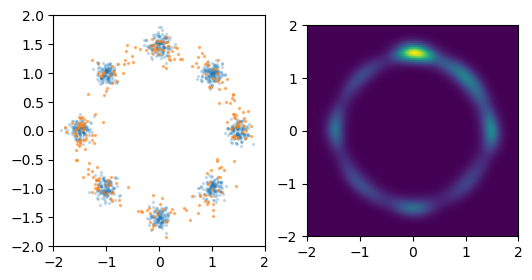

11100 [  0.10623502 -71.20202148  -0.37469978]
11200 [  0.09636513 -72.19726036  -0.36407895]
11300 [  0.11128014 -72.24135948  -0.37919686]
11400 [  0.1161143  -72.1475322   -0.38012111]
11500 [  0.10066449 -72.77468987  -0.35449664]
11600 [  0.10454767 -72.35757713  -0.36850841]
11700 [  0.10244442 -71.97369522  -0.38372739]
11800 [  0.09587087 -73.58934639  -0.37962819]
11900 [  0.09785992 -73.12792206  -0.39442102]
12000 [  0.10890123 -72.69584206  -0.38235592]


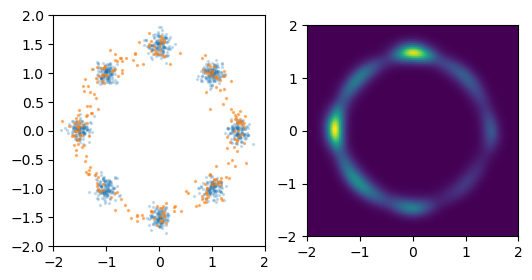

12100 [  0.10504153 -72.68483131  -0.39432309]
12200 [  0.10980872 -71.32581993  -0.40487588]
12300 [  0.0957609  -73.01366096  -0.36661318]
12400 [  0.09949978 -73.05753418  -0.37733114]
12500 [  0.10259659 -72.99055122  -0.39412361]
12600 [  0.10012024 -73.21551392  -0.37618803]
12700 [  0.10069257 -73.23010094  -0.39402061]
12800 [  0.10380262 -71.93047394  -0.40441419]
12900 [  0.0983375  -73.74587982  -0.36602441]
13000 [  0.09253647 -73.6949482   -0.37793887]


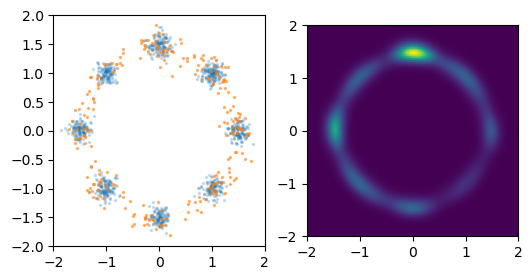

13100 [  0.10791345 -73.36487686  -0.38774434]
13200 [  0.09484203 -73.41060593  -0.37924306]
13300 [  0.10517721 -74.35574081  -0.37187918]
13400 [  0.11125597 -73.76189499  -0.3919519 ]
13500 [  0.11158859 -74.56136261  -0.38043858]
13600 [  0.10903927 -75.10053062  -0.36555034]
13700 [  0.0910676  -76.95497131  -0.35472405]
13800 [  0.08785944 -75.95760902  -0.40257545]
13900 [  0.0918401  -76.71223747  -0.38165075]
14000 [  0.10362606 -76.02270973  -0.40222985]


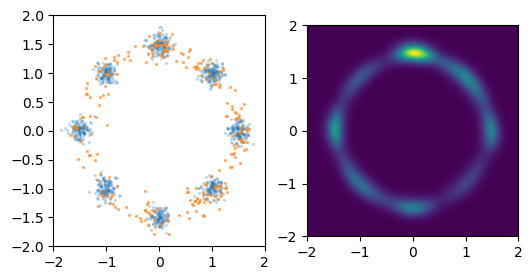

14100 [  0.10556991 -75.13714577  -0.39589134]
14200 [  0.11079487 -75.62640717  -0.37431945]
14300 [  0.09224562 -76.39371475  -0.37218918]
14400 [  0.11468506 -75.72101585  -0.39705162]
14500 [  0.11331747 -76.20732635  -0.38065092]
14600 [  0.09460741 -76.89119522  -0.38539108]
14700 [  0.09925678 -76.86150826  -0.39759953]
14800 [  0.09390586 -76.29376701  -0.38411521]
14900 [  0.100233   -76.77461273  -0.37556273]
15000 [  0.10746579 -77.59716911  -0.3808452 ]


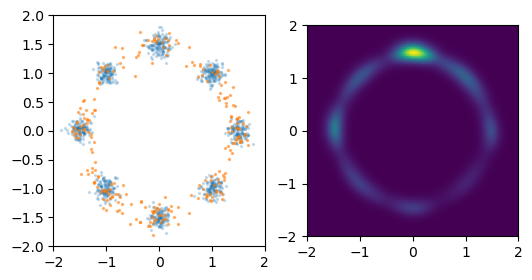

15100 [  0.10122789 -76.1456295   -0.40462812]
15200 [  0.09513849 -76.95180511  -0.38441075]
15300 [  0.09990969 -76.26486374  -0.39658396]
15400 [  0.10985262 -76.33116364  -0.37430714]
15500 [  0.10247689 -76.00950623  -0.37993114]
15600 [  0.10137246 -76.54333305  -0.37313979]
15700 [  0.11405312 -75.27036201  -0.39540193]
15800 [  0.10432622 -75.68707512  -0.37820364]
15900 [  0.10232119 -77.42746223  -0.3705615 ]
16000 [  0.10751257 -76.21419464  -0.40124847]


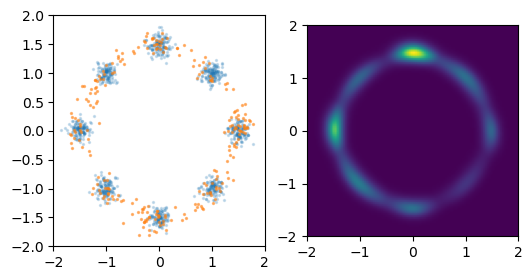

16100 [  0.11025813 -77.56159363  -0.38671778]
16200 [  0.09270098 -77.58959023  -0.3781166 ]
16300 [  0.10089928 -77.30871323  -0.39490269]
16400 [  0.09713165 -77.12691772  -0.38686856]
16500 [  0.1029881  -77.19929573  -0.36941542]
16600 [  0.10299103 -77.17697105  -0.37495205]
16700 [  0.0927928  -77.5198967   -0.36354259]
16800 [  0.11314264 -77.84653778  -0.39171994]
16900 [  0.09482288 -78.63398773  -0.35498757]
17000 [  0.09889047 -79.41971436  -0.36787126]


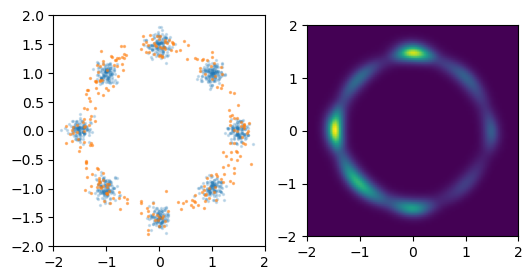

17100 [  0.1026349  -78.57082672  -0.37996437]
17200 [  0.10964966 -76.68330139  -0.39606382]
17300 [  0.10801991 -77.16270287  -0.36625725]
17400 [  0.09778077 -77.6144738   -0.37829466]
17500 [  0.10776813 -78.82072678  -0.36450907]
17600 [  0.10290154 -77.99767548  -0.38945533]
17700 [  0.09539642 -79.10848892  -0.35992093]
17800 [  0.10715754 -80.35920319  -0.36964572]
17900 [  0.10017078 -79.2952845   -0.39186591]
18000 [  0.09214142 -80.37656143  -0.37566017]


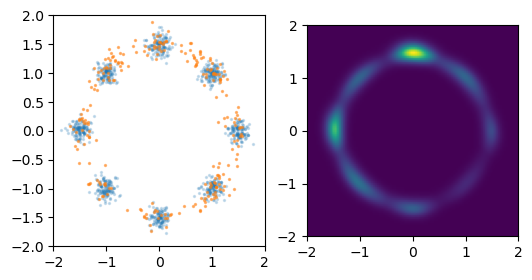

18100 [  0.09926159 -79.67523071  -0.39506695]
18200 [  0.09258601 -79.4397538   -0.37746073]
18300 [  0.09627172 -80.72785362  -0.34539464]
18400 [  0.09411048 -82.27175354  -0.36781318]
18500 [  0.11078903 -81.27846794  -0.39033429]
18600 [  0.09547972 -80.44709259  -0.39332793]
18700 [  0.10384604 -81.7172554   -0.3584072 ]
18800 [  0.10080854 -81.32960442  -0.37686426]
18900 [  0.0987939  -82.11715462  -0.35158731]
19000 [  0.09762106 -82.64423889  -0.38753871]


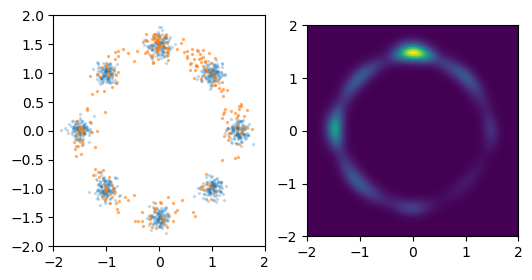

19100 [  0.10365589 -82.05574646  -0.39601756]
19200 [  0.10098033 -81.3735553   -0.37553235]
19300 [  0.09895901 -82.35252663  -0.3758005 ]
19400 [  0.09064948 -83.53648079  -0.37964333]
19500 [  0.1032293  -82.87571991  -0.38591252]
19600 [  0.10125716 -82.30026802  -0.39901829]
19700 [  0.09896124 -82.94789062  -0.38976264]
19800 [  0.10226499 -82.25331619  -0.38188515]
19900 [  0.09498997 -81.98227036  -0.38392229]
20000 [  0.10245548 -82.39986389  -0.37814084]


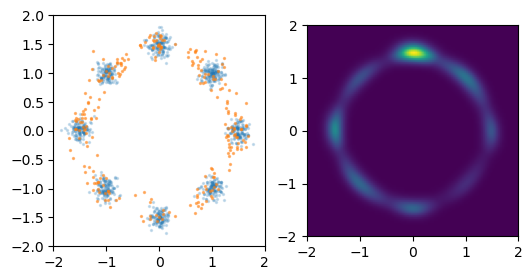

20100 [  0.0910464  -83.25562531  -0.37076355]
20200 [  0.08545371 -83.65532349  -0.3787737 ]
20300 [  0.1026312  -84.69901123  -0.37051976]
20400 [  0.09285067 -85.26012695  -0.37892169]
20500 [  0.08969003 -84.04984795  -0.39068593]
20600 [  0.09938496 -85.1139193   -0.36507803]
20700 [  0.1012316  -86.96940903  -0.37433355]
20800 [  0.09985187 -86.70998764  -0.37993833]
20900 [  0.09412974 -87.01923737  -0.38501245]
21000 [  0.09865109 -85.86714066  -0.39309422]


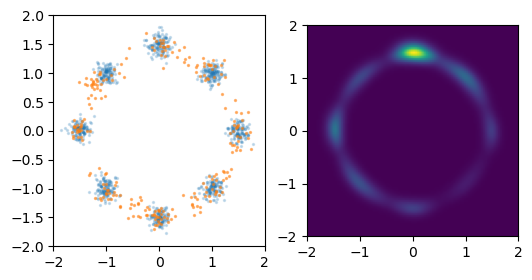

21100 [  0.09792389 -85.79402008  -0.38485093]
21200 [  0.09844307 -85.30521866  -0.37889297]
21300 [  0.10310876 -87.85203995  -0.38337214]
21400 [ 8.68256501e-02 -8.76369063e+01 -3.88167009e-01]
21500 [  0.09093245 -88.13521057  -0.37269927]
21600 [  0.09690883 -88.02741318  -0.39377377]
21700 [  0.09881106 -88.21824158  -0.38165046]
21800 [  0.09190197 -88.0590126   -0.38762603]
21900 [  0.09733087 -87.71267876  -0.37267484]
22000 [  0.08909446 -88.22423462  -0.39934066]


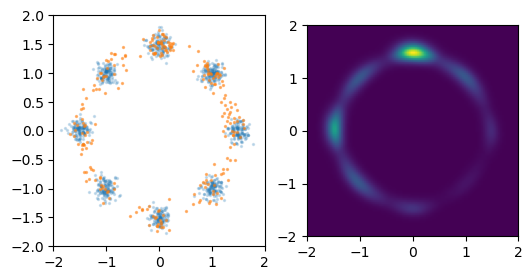

22100 [  0.09228573 -87.91401123  -0.38344315]
22200 [ 7.95343831e-02 -9.00707641e+01 -3.75628700e-01]
22300 [  0.11075053 -89.65888641  -0.39227992]
22400 [  0.09547087 -89.00119484  -0.37026581]
22500 [  0.09605556 -89.19577835  -0.37678495]
22600 [  0.09967528 -88.95626114  -0.38608272]
22700 [  0.09736501 -88.66056931  -0.36766799]
22800 [  0.09211187 -88.54437904  -0.39535062]
22900 [  0.08888721 -87.78452065  -0.38686733]


KeyboardInterrupt: 

In [41]:
bs = 256
N = 20
Tmax = 1
dt = torch.tensor(Tmax/N)
losses = []

opt_energy.param_groups[0]['lr'] = 1e-5


def lognormal(x, mean, var): return -0.5 * ((x - mean)**2 / var + var.log() + np.log(2*np.pi)).sum(-1)

for it in range(100000):
    opt.zero_grad()

    x = torch.zeros((bs, 2))
    # make x a sample from the dataset
    x[:bs//2] = dataset[torch.randint(0, len(dataset), (bs//2,))] + torch.randn(bs//2, 2)*0.2
    x[bs//2:] = x[:bs//2]

    t = torch.zeros((bs, 1))

    logpf = torch.zeros((bs,))
    logpb = torch.zeros((bs,))
    logr = torch.zeros((bs,))

    for i in range(N):
        driftvar = nn(torch.cat([x, t], -1))
        drift = driftvar[..., :2]
        var = driftvar[..., 2:].exp()
        x_next = x + drift*dt + torch.randn_like(x)*np.sqrt(dt)*(var.sqrt())# + (0 if it%2==0 else 0.25))
        x_next = x_next.detach()
        logpf += lognormal(x_next, x + drift*dt, var*dt)

        driftvar_back = nn_back(torch.cat([x_next, t+dt], -1))
        drift_back = driftvar_back[..., :2]
        var_back = driftvar_back[..., 2:].exp()
        logpb += lognormal(x, x_next - dt*drift_back, var_back*dt)

        x = x_next
        t = t + dt

    logr = -energy(x)[...,0]

    logz = (logr + logpb - logpf).mean()
    logz_iw = (logr + logpb - logpf).logsumexp(-1) - np.log(bs)

    loss_pf = ((logr + logpb.detach() - logpf)).view(2,-1).var(0).mean()
    loss_pb = -logpb.mean() #* (1 if it%2==0 else 0)

    (loss_pf+loss_pb).backward()
    opt.step()

    

    opt_energy.zero_grad()
    neg = energy(x.detach()).mean()
    pos = energy(dataset).mean()
    loss_energy = (pos - neg) #* (1 if it%2==0 else 0)
    loss_energy.backward()
    opt_energy.step()

    losses.append((loss_pf.item(),  loss_pb.item(),  loss_energy.item()))

    if it % 100 == 0:
        print(it, np.array(losses)[-100:].mean(0))
    if it % 1000 == 0:
        plt.figure(figsize=(6,3))
        plt.subplot(121)
        plt.scatter(dataset[:, 0], dataset[:, 1], s=2, alpha=0.2)
        plt.scatter(x[:, 0].detach().numpy(), x[:, 1].detach().numpy(), s=2, alpha=0.5)
        plt.xlim(-2,2);plt.ylim(-2,2)

        plt.subplot(122)
        X = torch.meshgrid(torch.linspace(-2, 2, 100), torch.linspace(-2, 2, 100))
        X = torch.stack(X, -1).view(-1, 2)
        with torch.no_grad():
            plt.imshow((-energy(X)).exp().view(100, 100).numpy().T[::-1], extent=(-2, 2, -2, 2))
        plt.show()


/var/folders/cx/2l1rdkkx5vg9h87plft2cx2w0000gn/T/ipykernel_59124/1724943518.py:14: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  traj[i+1] = x + drift*dt + torch.randn_like(x)*np.sqrt(dt)*(var.sqrt() + 0.)


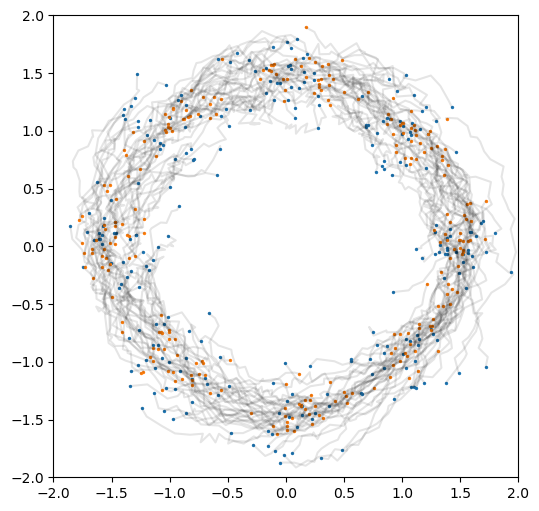

In [38]:
with torch.no_grad():

    x = dataset[torch.randint(0, len(dataset), (bs,))]+ torch.randn(bs, 2)*0.2
    t = torch.zeros((bs, 1))

    traj = torch.zeros((N+1, bs, 2))
    traj[0] = x

    for i in range(N):
        x = traj[i]
        driftvar = nn(torch.cat([x, t], -1))
        drift = driftvar[..., :2]
        var = driftvar[..., 2:].exp()
        traj[i+1] = x + drift*dt + torch.randn_like(x)*np.sqrt(dt)*(var.sqrt() + 0.)

        t = t + dt


    plt.figure(figsize=(6,6))
    for i in range(bs):
        plt.plot(traj[:, i, 0].numpy(), traj[:, i, 1].numpy(), color='black', alpha=0.1)
    plt.scatter(traj[0, :, 0].numpy(), traj[0, :, 1].numpy(), s=2)
    plt.scatter(traj[-1, :, 0].numpy(), traj[-1, :, 1].numpy(), s=2)
    plt.xlim(-2,2);plt.ylim(-2,2)
    plt.show()


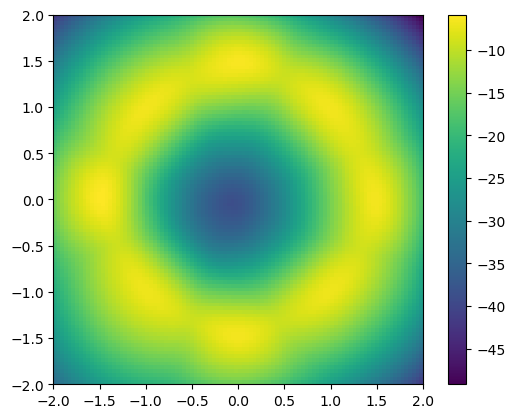

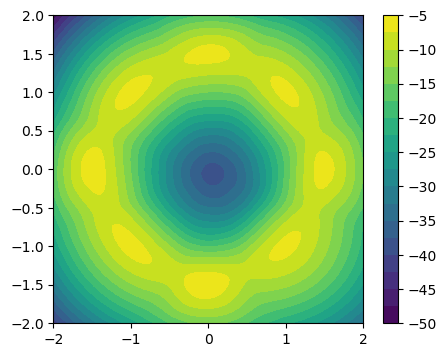

In [23]:
X = torch.meshgrid(torch.linspace(-2, 2, 100), torch.linspace(-2, 2, 100))
X = torch.stack(X, -1).view(-1, 2)
with torch.no_grad():
    plt.imshow((-energy(X)).view(100, 100).numpy().T[::-1], extent=(-2, 2, -2, 2))
    plt.colorbar()
plt.show()

plt.figure(figsize=(5,4))
# do a contour plot
X = torch.meshgrid(torch.linspace(-2, 2, 100), torch.linspace(-2, 2, 100))
X = torch.stack(X, -1).view(-1, 2)
with torch.no_grad():
    plt.contourf(X[:, 0].view(100, 100).numpy(), X[:, 1].view(100, 100).numpy(), (-energy(X)).view(100, 100).numpy().T[::-1], levels=20)
    plt.colorbar()
plt.show()

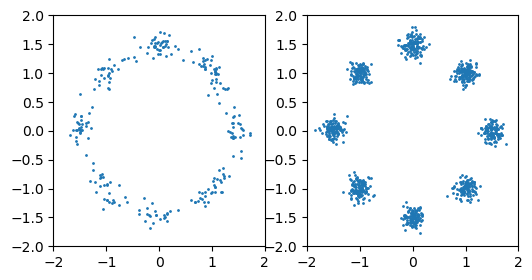

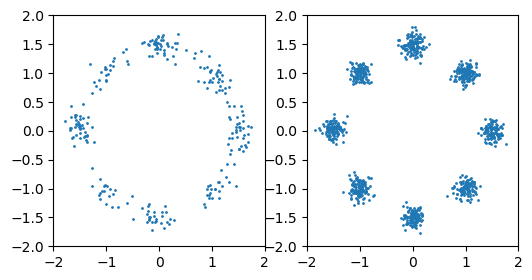

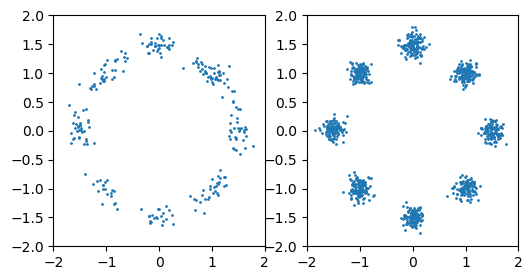

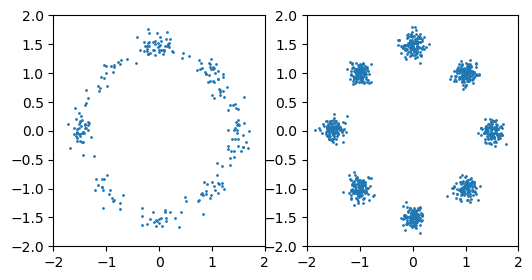

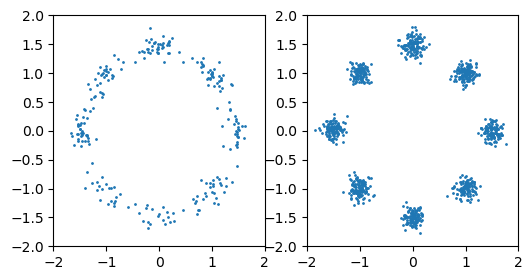

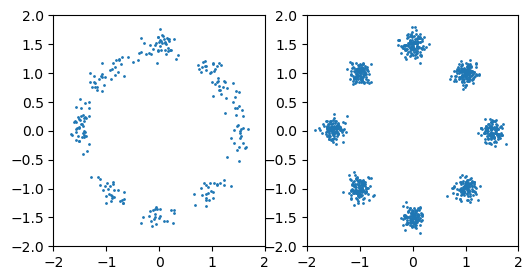

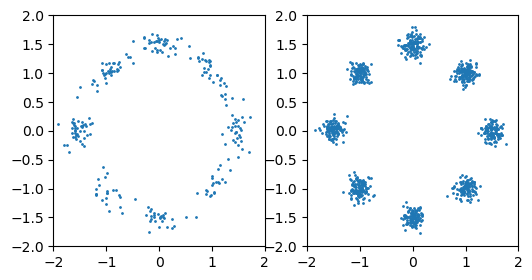

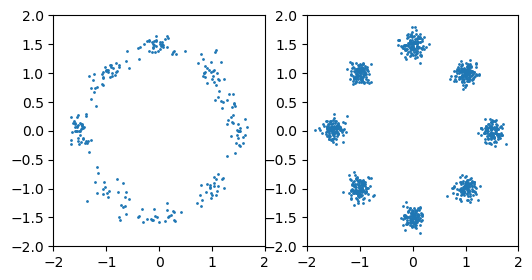

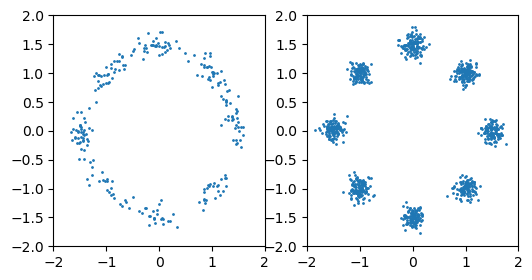

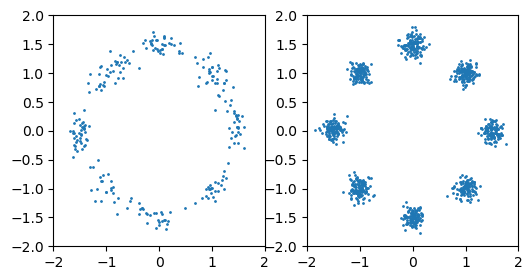

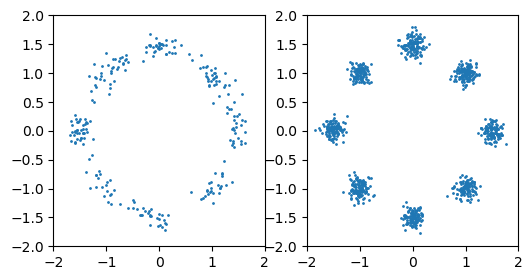

In [24]:
# x = torch.zeros((1000,2))
langevin_step_size = 1e-2
for i in range(10001):
    langevin_step_size = 0.01*(0.1)**(i/3000)
    if i % 1000 == 0:
        plt.figure(figsize=(6,3))
        plt.subplot(121)
        plt.scatter(x[:, 0].detach().numpy(), x[:, 1].detach().numpy(), s=1)
        plt.xlim(-2,2);plt.ylim(-2,2)
        plt.subplot(122)
        plt.scatter(dataset[:, 0], dataset[:, 1], s=1)

        plt.xlim(-2,2);plt.ylim(-2,2)
        plt.show()

    x_ = x.clone().detach().requires_grad_()
    energy_grad = torch.autograd.grad(energy(x_).sum(), x_)[0]
    x -= energy_grad * langevin_step_size + torch.randn_like(x)*np.sqrt(2*langevin_step_size)
    

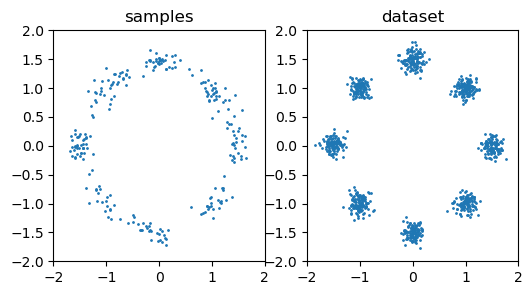

In [26]:
plt.figure(figsize=(6,3))
plt.subplot(121);plt.title('samples')
plt.scatter(x[:, 0].detach().numpy(), x[:, 1].detach().numpy(), s=1)
plt.xlim(-2,2);plt.ylim(-2,2)
plt.subplot(122);plt.title('dataset')
plt.scatter(dataset[:, 0], dataset[:, 1], s=1)

plt.xlim(-2,2);plt.ylim(-2,2)
plt.show()

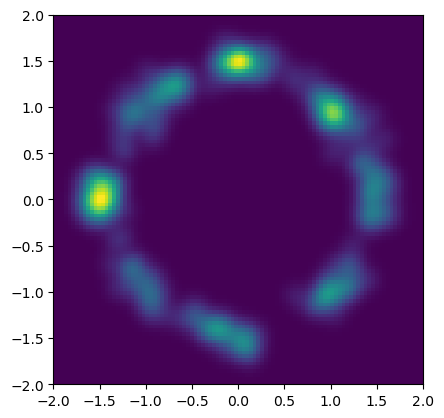

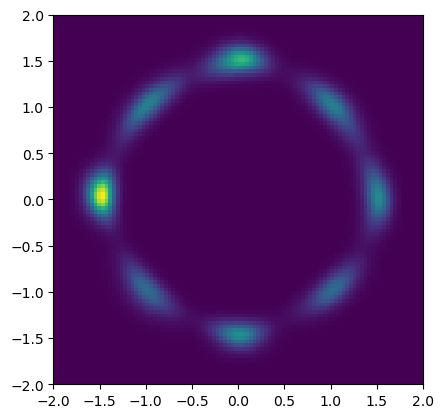

In [34]:
# kde plot of x
# x: torch.tensor (1000, 2)

kde = torch.zeros(100, 100)
for i in range(100):
    for j in range(100):
        point = torch.tensor([[-2 + i*0.04, -2 + j*0.04]])
        kde[i,j] = (-(x-point).pow(2).sum(-1)/(2*0.1**2)).exp().sum()
# kde = - (x - grid).pow(2).sum(-1)/(2*0.1**2)

plt.imshow(kde.numpy().T[::-1], extent=(-2, 2, -2, 2))
plt.show()

kde = torch.zeros(100, 100)
for i in range(100):
    for j in range(100):
        with torch.no_grad():
            point = torch.tensor([[-2 + i*0.04, -2 + j*0.04]])
            kde[i,j] = (-energy(point)).exp()

plt.imshow(kde.numpy().T[::-1], extent=(-2, 2, -2, 2))